Muon momentum: mean = 609.05 MeV/c, std = 148.44 MeV/c
Muon energy: mean = 795.47 MeV, std = 149.27 MeV
Muon angle: mean = 59.20°, std = 29.57°


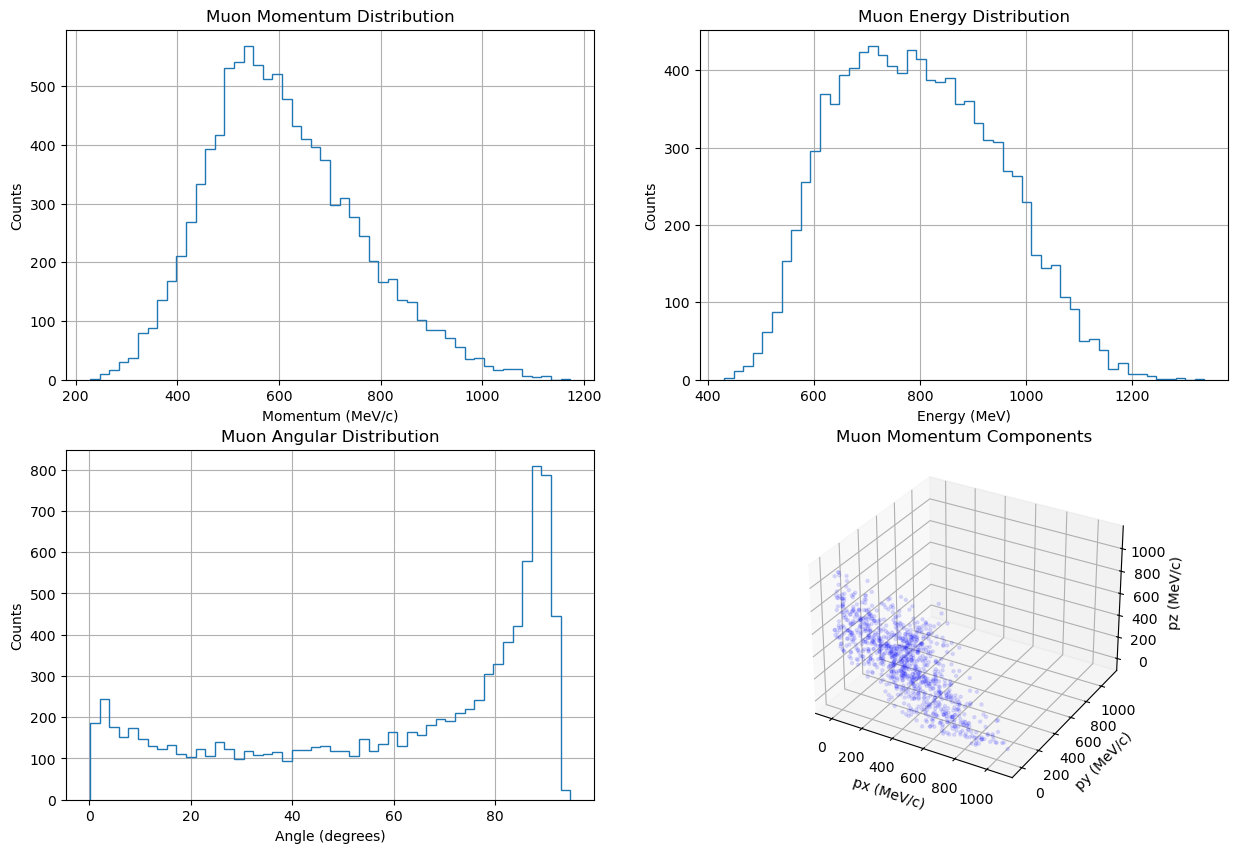

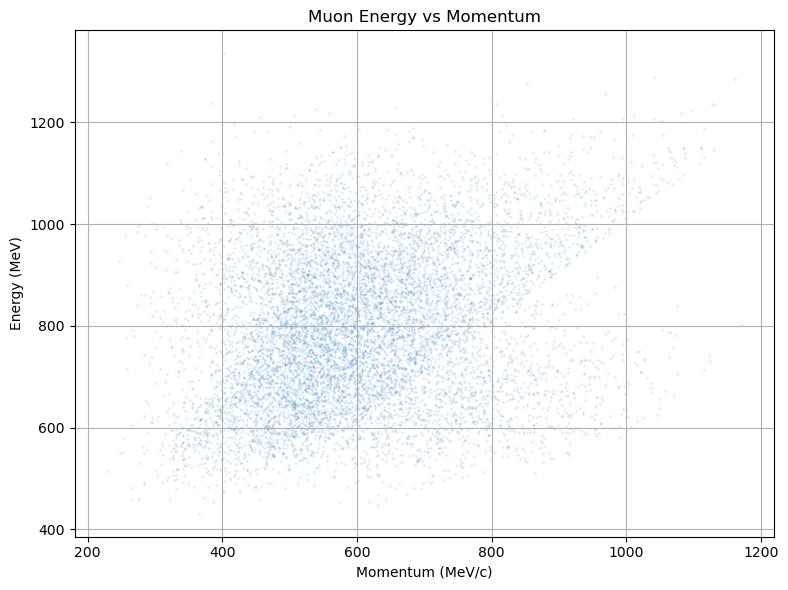

In [2]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

@dataclass
class Particle:
    """Class to store particle properties and kinematics"""
    mass: float  # MeV/c^2
    momentum: np.ndarray  # MeV/c
    energy: float  # MeV
    
    @property
    def gamma(self) -> float:
        """Relativistic gamma factor"""
        return self.energy / self.mass
    
    @property
    def beta(self) -> float:
        """Velocity as fraction of c"""
        return np.sqrt(1 - 1/self.gamma**2)

class PionDecaySimulator:
    """Simulates π+ → μ+ + νμ decay"""
    
    # Particle masses in MeV/c^2
    PION_MASS = 139.57  # π+ mass
    MUON_MASS = 105.66  # μ+ mass
    NU_MASS = 0.0  # νμ mass (approximated as massless)
    
    def __init__(self, n_events: int, pion_momentum_mean: float, pion_momentum_sigma: float):
        """
        Initialize the simulator
        
        Args:
            n_events: Number of decay events to simulate
            pion_momentum_mean: Mean initial pion momentum in MeV/c
            pion_momentum_sigma: Standard deviation of initial pion momentum in MeV/c
        """
        self.n_events = n_events
        self.pion_momentum_mean = pion_momentum_mean
        self.pion_momentum_sigma = pion_momentum_sigma
        
    def generate_initial_pions(self) -> List[Particle]:
        """Generate initial pion distribution with Gaussian momentum"""
        # Generate momentum magnitudes from Gaussian distribution
        momenta = np.random.normal(self.pion_momentum_mean, 
                                 self.pion_momentum_sigma, 
                                 self.n_events)
        
        # Generate random directions uniformly on a sphere
        phi = np.random.uniform(0, 2*np.pi, self.n_events)
        cos_theta = np.random.uniform(-1, 1, self.n_events)
        sin_theta = np.sqrt(1 - cos_theta**2)
        
        # Convert to Cartesian coordinates
        px = momenta * sin_theta * np.cos(phi)
        py = momenta * sin_theta * np.sin(phi)
        pz = momenta * cos_theta
        
        pions = []
        for i in range(self.n_events):
            momentum = np.array([px[i], py[i], pz[i]])
            energy = np.sqrt(self.PION_MASS**2 + np.sum(momentum**2))
            pions.append(Particle(self.PION_MASS, momentum, energy))
            
        return pions
    
    def decay_in_rest_frame(self) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate muon and neutrino momenta in pion rest frame"""
        # In pion rest frame, momentum magnitude is fixed by conservation laws
        p_mag = np.sqrt((self.PION_MASS**2 - (self.MUON_MASS + self.NU_MASS)**2) *
                       (self.PION_MASS**2 - (self.MUON_MASS - self.NU_MASS)**2)) / (2 * self.PION_MASS)
        
        # Generate random directions uniformly on a sphere
        phi = np.random.uniform(0, 2*np.pi, self.n_events)
        cos_theta = np.random.uniform(-1, 1, self.n_events)
        sin_theta = np.sqrt(1 - cos_theta**2)
        
        # Convert to Cartesian coordinates
        px = p_mag * sin_theta * np.cos(phi)
        py = p_mag * sin_theta * np.sin(phi)
        pz = p_mag * cos_theta
        
        # Stack components into momentum vectors
        muon_momenta = np.column_stack([px, py, pz])
        # Neutrino momenta are opposite to conserve momentum
        nu_momenta = -muon_momenta
        
        return muon_momenta, nu_momenta
    
    def boost_to_lab_frame(self, rest_momentum: np.ndarray, mass: float, 
                          pion: Particle) -> Particle:
        """
        Lorentz boost from pion rest frame to lab frame
        
        Args:
            rest_momentum: Particle momentum in pion rest frame
            mass: Particle mass
            pion: Parent pion particle
            
        Returns:
            Particle: Boosted particle in lab frame
        """
        # Calculate rest frame energy
        E_rest = np.sqrt(mass**2 + np.sum(rest_momentum**2))
        
        # Get boost parameters from pion
        beta = pion.momentum / pion.energy
        gamma = pion.gamma
        
        # Perform Lorentz boost
        p_parallel = np.sum(rest_momentum * beta) / np.linalg.norm(beta)
        p_parallel_vec = p_parallel * beta / np.linalg.norm(beta)
        p_perp_vec = rest_momentum - p_parallel_vec
        
        p_lab_parallel = gamma * (p_parallel + beta * E_rest)
        p_lab = p_perp_vec + p_lab_parallel * beta / np.linalg.norm(beta)
        
        E_lab = gamma * (E_rest + np.sum(beta * rest_momentum))
        
        return Particle(mass, p_lab, E_lab)
    
    def simulate(self) -> Tuple[List[Particle], List[Particle], List[Particle]]:
        """
        Run full simulation of pion decays
        
        Returns:
            Tuple containing lists of:
            - Initial pions
            - Resulting muons in lab frame
            - Resulting neutrinos in lab frame
        """
        # Generate initial pions
        pions = self.generate_initial_pions()
        
        # Get rest frame momenta
        muon_momenta_rest, nu_momenta_rest = self.decay_in_rest_frame()
        
        # Boost each decay product to lab frame
        muons = []
        neutrinos = []
        for i in range(self.n_events):
            muon = self.boost_to_lab_frame(muon_momenta_rest[i], 
                                         self.MUON_MASS, 
                                         pions[i])
            nu = self.boost_to_lab_frame(nu_momenta_rest[i],
                                       self.NU_MASS,
                                       pions[i])
            muons.append(muon)
            neutrinos.append(nu)
            
        return pions, muons, neutrinos

def analyze_results(muons: List[Particle]) -> None:
    """Analyze and plot results of the simulation"""
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Extract muon momenta and energies
    momenta = np.array([np.linalg.norm(muon.momentum) for muon in muons])
    energies = np.array([muon.energy for muon in muons])
    angles = np.array([np.arccos(muon.momentum[2]/np.linalg.norm(muon.momentum)) 
                      for muon in muons])
    
    # Print summary statistics
    print(f"Muon momentum: mean = {np.mean(momenta):.2f} MeV/c, "
          f"std = {np.std(momenta):.2f} MeV/c")
    print(f"Muon energy: mean = {np.mean(energies):.2f} MeV, "
          f"std = {np.std(energies):.2f} MeV")
    print(f"Muon angle: mean = {np.rad2deg(np.mean(angles)):.2f}°, "
          f"std = {np.rad2deg(np.std(angles)):.2f}°")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Momentum distribution
    ax1 = fig.add_subplot(221)
    ax1.hist(momenta, bins=50, histtype='step', label='Muon momentum')
    ax1.set_xlabel('Momentum (MeV/c)')
    ax1.set_ylabel('Counts')
    ax1.set_title('Muon Momentum Distribution')
    ax1.grid(True)
    
    # 2. Energy distribution
    ax2 = fig.add_subplot(222)
    ax2.hist(energies, bins=50, histtype='step', label='Muon energy')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_ylabel('Counts')
    ax2.set_title('Muon Energy Distribution')
    ax2.grid(True)
    
    # 3. Angular distribution
    ax3 = fig.add_subplot(223)
    ax3.hist(np.rad2deg(angles), bins=50, histtype='step', label='Muon angle')
    ax3.set_xlabel('Angle (degrees)')
    ax3.set_ylabel('Counts')
    ax3.set_title('Muon Angular Distribution')
    ax3.grid(True)
    
    # 4. 3D momentum distribution
    ax4 = fig.add_subplot(224, projection='3d')
    px = np.array([muon.momentum[0] for muon in muons])
    py = np.array([muon.momentum[1] for muon in muons])
    pz = np.array([muon.momentum[2] for muon in muons])
    
    # Plot only a subset of points for clarity
    subset_size = min(1000, len(muons))
    idx = np.random.choice(len(muons), subset_size, replace=False)
    
    ax4.scatter(px[idx], py[idx], pz[idx], c='b', marker='.', alpha=0.1)
    ax4.set_xlabel('px (MeV/c)')
    ax4.set_ylabel('py (MeV/c)')
    ax4.set_zlabel('pz (MeV/c)')
    ax4.set_title('Muon Momentum Components')
    
    # Add momentum-energy correlation plot
    fig2 = plt.figure(figsize=(8, 6))
    ax5 = fig2.add_subplot(111)
    ax5.scatter(momenta, energies, alpha=0.1, s=1)
    ax5.set_xlabel('Momentum (MeV/c)')
    ax5.set_ylabel('Energy (MeV)')
    ax5.set_title('Muon Energy vs Momentum')
    ax5.grid(True)
    
    # Make plots tight and show
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize simulator with 10000 events
    # Pions with mean momentum 1000 MeV/c and sigma 100 MeV/c
    simulator = PionDecaySimulator(10000, 1000.0, 100.0)
    
    # Run simulation
    pions, muons, neutrinos = simulator.simulate()
    
    # Analyze results
    analyze_results(muons)